In [1]:
# Import the modules
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Load data into a pandas dataframe here
df_daily = pd.read_csv("Total_Average_features.csv",delimiter=',',low_memory=False)

In [3]:
df_daily.head(5)

,Unnamed: 0,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Weight_diff
0,0,26.00351,26.74042,16.63030,8.31906,0.39997,319.83208,0.00031
1,1,25.38011,32.65985,12.11747,8.39112,0.49023,310.62576,0.00059
2,2,25.38046,32.78354,13.70149,8.42363,0.47966,305.31809,0.00079
3,3,24.54964,20.24947,9.74304,8.45261,0.50144,303.09542,0.00041
4,4,24.37354,14.44697,10.59094,8.49101,0.48472,312.37094,0.00095


In [4]:
df_daily.drop(['Unnamed: 0'], axis=1, inplace=True) 

In [5]:
df_daily.head(5)

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Weight_diff
0,26.00351,26.74042,16.63030,8.31906,0.39997,319.83208,0.00031
1,25.38011,32.65985,12.11747,8.39112,0.49023,310.62576,0.00059
2,25.38046,32.78354,13.70149,8.42363,0.47966,305.31809,0.00079
3,24.54964,20.24947,9.74304,8.45261,0.50144,303.09542,0.00041
4,24.37354,14.44697,10.59094,8.49101,0.48472,312.37094,0.00095


<AxesSubplot:>

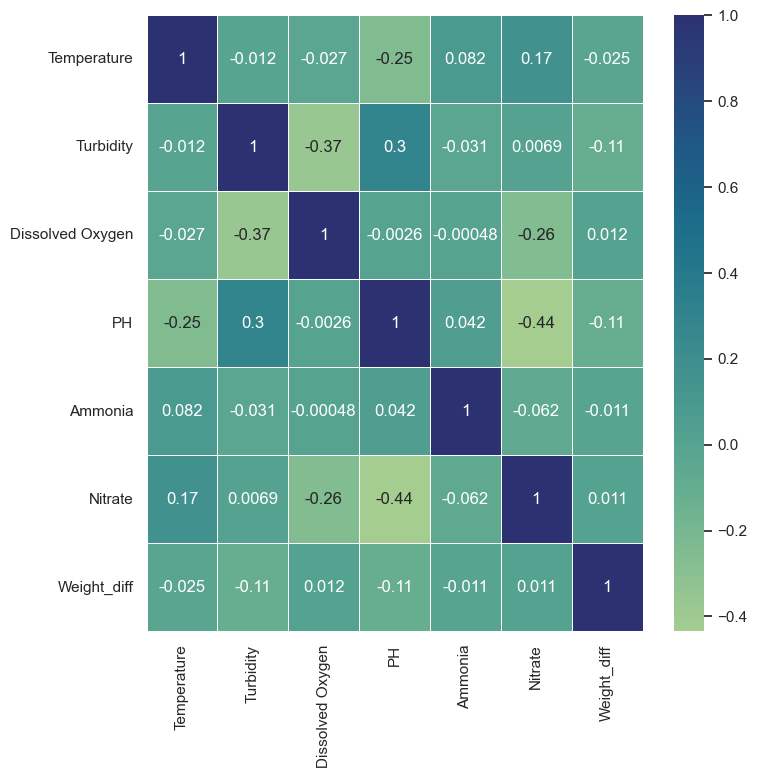

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(df_daily.corr(), annot=True, cmap='crest',linewidth=.5)

In [7]:
random_state=1234

Create training and testing datasets

In [8]:
X, Y = df_daily[['Temperature', 'Turbidity','Dissolved Oxygen','PH','Ammonia','Nitrate']], df_daily['Weight_diff']

X_train, X_test, y_train, y_test = \
  train_test_split(X, Y, test_size=0.4, random_state=333)

In [9]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

346 231 346 231


# Modelling

In [10]:
from sklearn.pipeline import make_pipeline



Then we're going to use MinMaxScaler as one of our core transformations to our data. It takes our data and standardises it so that it's on the same scale as the rest of our data. This ensures that the algorithms treat the features as equals regardless of magnitudes.

This is from the preprocessing part of scikit learn.



In [12]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMRegressor

Make some pipelines! 

In [13]:
pipelines = {
    'rf':make_pipeline(MinMaxScaler(), RandomForestRegressor(random_state=random_state)),
    'gb':make_pipeline(MinMaxScaler(), GradientBoostingRegressor(random_state=random_state)),
    'enet':make_pipeline(MinMaxScaler(), ElasticNet(random_state=random_state)),
    'ridge':make_pipeline(MinMaxScaler(), Ridge(random_state=random_state)),
    'lasso':make_pipeline(MinMaxScaler(), Lasso(random_state=random_state)),
    'lgbm': make_pipeline(MinMaxScaler(), LGBMRegressor(random_state=random_state))
}

Setup a tuning grid

Each algorithm will have it's own grid and those grids will be stored together in a python dictionary.

In [14]:
grid = {
    'rf':{'randomforestregressor__n_estimators':[10,20,30]},
    'gb':{'gradientboostingregressor__alpha':[0.5,0.9,0.99]},
    'enet':{'elasticnet__alpha':[0.5,0.9,0.99]},
    'ridge':{'ridge__alpha':[0.5,0.9,0.99]},
    'lasso':{'lasso__alpha':[0.5,0.9,0.99]},
    'lgbm': {'lgbmregressor__num_leaves': [10, 20, 30], 'lgbmregressor__learning_rate': [0.1, 0.01, 0.001]}
}

In [15]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

Train model using Grid Search

As part of using GridSearch we are also doing cross validation. This holds our a section of your data and tests it to make sure the algorithm is learning to predict well.

This can be done using GridSearchCV from scikit learn.

In [16]:
from sklearn.model_selection import  GridSearchCV

In [17]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, grid[algo], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fit_models[algo] = model
    print(algo, 'model has been fit.')


rf model has been fit.
gb model has been fit.
enet model has been fit.
ridge model has been fit.
lasso model has been fit.
lgbm model has been fit.


Let's recap:

   Imported the required libraries for modern machine learning
   Setup machine learning pipelines and used StandardScaler
   Constructed a hyperparameter tuning grid for HPO
   Used Grid Search CV to train our model


In [18]:
fit_models

{'rf': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                        ('randomforestregressor',
                                         RandomForestRegressor(random_state=1234))]),
              n_jobs=-1,
              param_grid={'randomforestregressor__n_estimators': [10, 20, 30]}),
 'gb': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                        ('gradientboostingregressor',
                                         GradientBoostingRegressor(random_state=1234))]),
              n_jobs=-1,
              param_grid={'gradientboostingregressor__alpha': [0.5, 0.9, 0.99]}),
 'enet': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                        ('elasticnet',
                                         ElasticNet(random_state=1234))]),
              n_jobs=-1, param_grid={'el

In [19]:
fit_models['rf']

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=1234))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 20, 30]})

And make a prediction by using the .predict() method.

In [20]:
fit_models['rf'].predict(X_test)

array([3.62045707e-03, 2.50658430e-03, 7.87153033e-01, 1.09221344e-03,
       6.56991413e-03, 8.13887155e-04, 3.95956824e-01, 2.99296938e-02,
       1.60174628e-02, 2.90966508e-03, 4.29228553e-02, 4.15599162e-02,
       3.89426551e-03, 1.47597255e-01, 8.08986487e-02, 1.71661465e-03,
       3.54176525e-03, 2.34001876e-03, 4.33708621e-04, 8.11860705e-03,
       5.87138122e-04, 1.65095060e-03, 3.86051261e-03, 7.07828944e-02,
       5.12367115e-01, 1.76841166e-03, 1.51386181e-02, 1.78643894e-02,
       6.03167211e-03, 1.17580396e-02, 9.72234035e-03, 3.31179942e-02,
       2.46249103e-02, 1.48694816e+00, 1.78575748e-02, 1.37261225e-03,
       4.70533429e-02, 9.29088848e-03, 1.83320713e-03, 1.58365511e-03,
       9.43705695e-02, 4.63356368e-04, 1.67412736e-03, 2.85098104e-04,
       2.57775263e-02, 6.15813926e-02, 5.75892702e-04, 3.15641892e-02,
       8.71046970e-01, 1.89221497e-03, 3.34271203e-02, 2.56977722e-02,
       5.42861117e-03, 9.64984957e-03, 9.79356883e-03, 1.69008984e-03,
      

Loop through each model inside of the fit_models dictionary and calculate mse using the mean_squared_error() score 

In [21]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print('{} scores - R\u00B2:{} MSE:{}'.format(algo, r2_score(y_test, yhat), mean_squared_error(y_test, yhat)))

rf scores - R²:0.4861907210005292 MSE:0.03404097698853314
gb scores - R²:0.615417997185966 MSE:0.025479390199977296
enet scores - R²:-0.0034046014667443725 MSE:0.06647772694029701
ridge scores - R²:0.04438394026462811 MSE:0.06331163260163311
lasso scores - R²:-0.0034046014667443725 MSE:0.06647772694029701
lgbm scores - R²:0.03182577484376059 MSE:0.06414363824571644


Knowing that a lower MSE is better, we can tell that the Gradient Boosting Regressor is performing the best.

Saving our models

In [22]:
bestmod = fit_models['gb'].best_estimator_

In [23]:
y_pred_test=bestmod.predict(X_test)

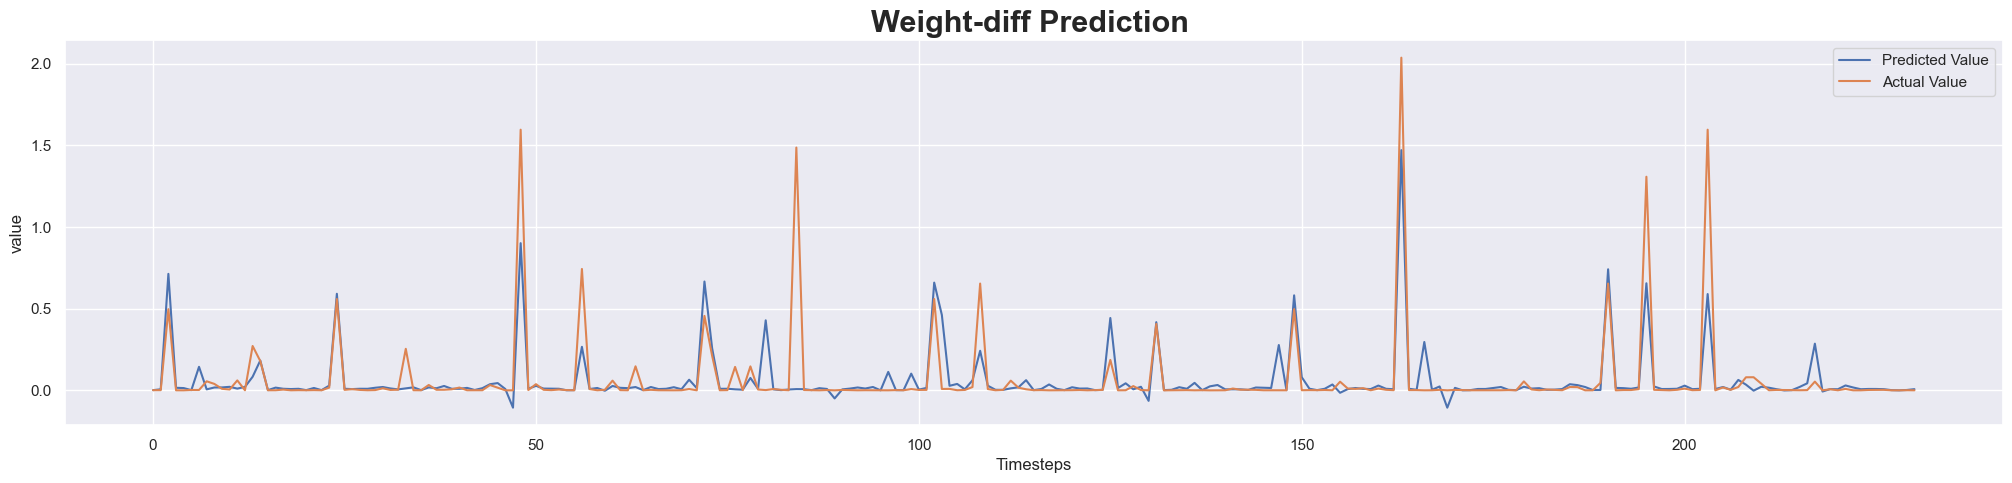

In [24]:
y_true_test = np.array(y_test, dtype = object).astype(np.float32)

y_pred_test=bestmod.predict(X_test)

fig_verify = plt.figure(figsize=(25, 5))
plt.plot(y_pred_test,label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Weight-diff Prediction ', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

Saving the predictions for Tableau Dashboard 

In [25]:
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('Tableau.csv', index = None)

Let's save this using pickle.

In [26]:
import pickle as pkl

In [27]:
with open('saved_model.pkl', 'wb') as f:
    pkl.dump(bestmod, f)